In this notebook, we're going to build a regression model that rates the motor impairment severity of patients with Parkinson's disease using time-series gait data. The dataset is taken from a [PhysioNet](https://www.physionet.org/) repository called ["Gait in Parkinson's Disease"](https://www.physionet.org/content/gaitpdb/1.0.0/) by Jeffrey Hausdorff .

# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install librosa
!pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import sklearn

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
!wget -rNcnp https://physionet.org/files/gaitpdb/1.0.0/

--2023-08-01 23:42:14--  https://physionet.org/files/gaitpdb/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/gaitpdb/1.0.0/index.html’

physionet.org/files     [ <=>                ]  36.17K  --.-KB/s    in 0.02s   

Last-modified header missing -- time-stamps turned off.
2023-08-01 23:42:14 (1.52 MB/s) - ‘physionet.org/files/gaitpdb/1.0.0/index.html’ saved [37036]

Loading robots.txt; please ignore errors.
--2023-08-01 23:42:14--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2023-08-01 23:42:15 (3.45 MB/s) - ‘physionet.org/robots.txt’ saved [22/22]

--2023-08-01 2

# Step 1: Define the Problem You Are Trying to Solve

Parkinson's disease is a chronic and progressive neurological disorder that results in tremor, rigidity, slowness, and postural instability. A disturbed gait is a common, debilitating symptom; patients with severe gait disturbances are prone to falls and may lose their functional independence. The goal of this dataset is enable researchers to investigate whether characteristics of gait can be used to automatically monitor the severity of Parkinson's disease over time.

This dataset is actually composed of data collected by three institutions. Together, these institutions recruited 93 patients with idiopathic PD and 73 healthy controls. During enrollment, subjects were asked to complete a number of clinical scales to assess the severity of their Parkinsonian symptoms. For this exercise, we will examine subject's scores on the ***Unified Parkinson's Disease Rating Scale (UPDRS)***. This scale is composed of four different parts, but we will focus on the portion that deals with motor control function (Part III).


During the study itself, subjects were asked to walk at their usual pace for approximately 2 minutes on level ground. Subjects were asked to repeat this protocol for multiple trials depending on the institution where the data was collected.

Underneath each foot were 8 sensors that measure force (in Newtons) as a function of time; the compilers of the dataset call this data the vertical ground reaction force (VGRF).  The output of each of these 16 sensors has been digitized and recorded at 100 Hz, and the records also include two signals that reflect the sum of the 8 sensor outputs for each foot.

| Column # | Description |
|----------|-------------|
| 1 | Time in seconds|
| 2–9 | VGRF on each of the 8 sensors located under the left foot |
|10–17 | VGRF on each of the 8 sensors located under the right foot |
| 18 | Total force under the left foot |
| 19 | Total force under the right foot |

The recording files are named according to the following convention: `{study_prefix}{subject_type}{subject_id}_{trial_id}.txt` (e.g., `GaCo01_01.txt`)

* `study_prefix`: Specifies the institution where the subject was recruited (either `Ga`, `Ju`, or `Si`)
* `subject_type`: Specifies whether the subject was a control (`Co`) or a patient (`Pt`)
* `subject_id`: Numerical identifier indicating the subject's number within the institution's cohort
* `trial_id`: Numerical identifier indicating the trial number. We will be using all trials except for any numbered `10`, which relates to a special protocol used by a single institution.

In [3]:
# The relevant folders and files associated with this dataset
base_folder = os.path.join('physionet.org', 'files', 'gaitpdb', '1.0.0')
label_filename = os.path.join(base_folder, 'demographics.xls')

# The names of the columns in the recordings
column_names = ['Time']
for i in range(1, 9):
    column_names.append(f'Left Sensor {i}')
for i in range(1, 9):
    column_names.append(f'Right Sensor {i}')
column_names.append('Left Foot')
column_names.append('Right Foot')

In [38]:
# Show the structure of one of the files
control_filename = 'GaCo01_01.txt'
patient_filename = 'GaPt03_01.txt'
control_df = pd.read_csv(os.path.join(base_folder, control_filename),
                         sep="\t", header=None, names=column_names)
patient_df = pd.read_csv(os.path.join(base_folder, patient_filename),
                    sep="\t", header=None, names=column_names)
control_df

,Time,Left Sensor 1,Left Sensor 2,Left Sensor 3,Left Sensor 4,Left Sensor 5,Left Sensor 6,Left Sensor 7,Left Sensor 8,Right Sensor 1,Right Sensor 2,Right Sensor 3,Right Sensor 4,Right Sensor 5,Right Sensor 6,Right Sensor 7,Right Sensor 8,Left Foot,Right Foot
0,0.0000,199.10,87.34,91.08,24.09,21.12,87.67,87.23,64.57,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,662.20,748.00
1,0.0100,199.10,87.34,91.08,24.09,21.12,87.67,87.23,64.57,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,662.20,748.00
2,0.0200,199.10,87.34,91.08,24.09,21.12,87.67,87.23,62.59,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,660.22,748.00
3,0.0300,199.10,87.34,91.08,24.09,21.12,87.67,89.10,64.57,163.90,77.55,112.42,48.07,13.75,105.49,144.98,79.53,664.07,745.69
4,0.0400,199.10,87.34,91.08,24.09,21.12,87.67,87.23,62.59,163.90,77.55,112.42,50.82,13.75,105.49,144.98,79.53,660.22,748.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12114,121.1315,305.91,85.14,58.08,0.00,0.00,0.00,0.00,0.00,15.73,11.66,4.73,33.88,33.00,255.42,432.19,147.29,449.13,933.90
12115,121.1415,331.54,134.75,79.31,11.99,0.00,3.85,0.00,0.00,15.73,9.35,4.73,11.22,24.75,230.34,420.42,151.80,561.44,868.34
12116,121.1515,352.44,181.94,102.96,39.60,0.00,17.49,2.97,0.00,13.97,9.35,4.73,5.61,19.25,192.39,402.82,154.00,697.40,802.12
12117,121.1615,352.44,202.40,124.74,43.01,8.47,50.71,7.59,0.00,13.97,6.93,0.00,0.00,13.75,143.66,373.34,151.80,789.36,703.45


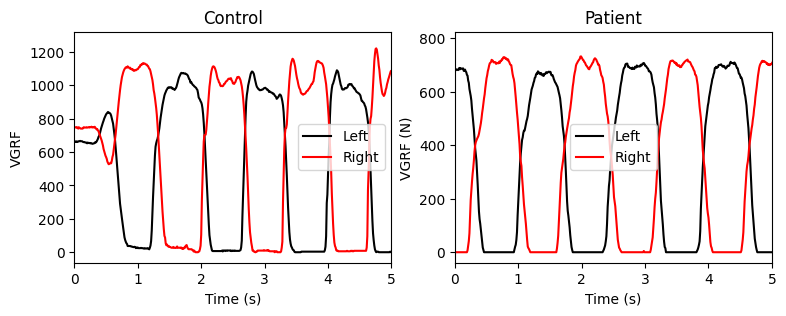

In [5]:
# Show snippets of the traces
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(control_df['Time'], control_df['Left Foot'], 'k-', label='Left')
plt.plot(control_df['Time'], control_df['Right Foot'], 'r-', label='Right')
plt.xlabel('Time (s)'), plt.ylabel('VGRF'), plt.title('Control')
plt.xlim(0, 5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(patient_df['Time'], patient_df['Left Foot'], 'k-', label='Left')
plt.plot(patient_df['Time'], patient_df['Right Foot'], 'r-', label='Right')
plt.xlabel('Time (s)'), plt.ylabel('VGRF (N)'), plt.title('Patient')
plt.xlim(0, 5)
plt.legend()
plt.show()

There are many ways we could structure this problem. For instance, we could create a binary classifier designed to discriminate people with and without Parkinson's disease. For the sake of this exercise, however, we are going to build a ***regression model*** that will predict a person's UPDRS Part III score as the label based on their gait characteristics. To ensure that our dataset is not heavily skewed towards assuming that people do not have any motor impairments, we are only going to look at data from patients (e.g., with `Pt` in the recording filename).

# Step 2: Create Your Features and Labels

## Creating the Labels

The demographic information about our subjects, including their UPDRS scores, are provided in an `.xls` file (note: they are also provided in a tab-limited `.txt` file, but that file has a formatting issue). Let's load this file and see what it looks like:

In [99]:
labels_df = pd.read_excel(label_filename)
labels_df.head()

,ID,Study,Group,Subjnum,Gender,Age,Height (meters),Weight (kg),HoehnYahr,UPDRS,UPDRSM,TUAG,Speed_01 (m/sec),Speed_10
0,GaPt03,Ga,PD,3,female,82,1.45,50.0,3.0,20.0,10.0,36.34,NaN,0.778
1,GaPt04,Ga,PD,4,male,68,1.71,NaN,2.5,25.0,8.0,11.00,0.642,0.818
2,GaPt05,Ga,PD,5,female,82,1.53,51.0,2.5,24.0,5.0,14.50,0.908,0.614
3,GaPt06,Ga,PD,6,male,72,1.70,82.0,2.0,16.0,13.0,10.47,0.848,0.937
4,GaPt07,Ga,PD,7,female,53,1.67,54.0,3.0,44.0,22.0,18.34,0.677,0.579


This file contains many different columns, but we are only going to concern ourselves with the subset of them. More specifically, we will use some of the demographic information as features, and we will use the UPDRSM score (i.e., UPDRS Part III) as our labels.

We are going to do a few things to make this `DataFrame` better serve our needs:
1. We will get rid of all of the rows and columns except for the ones that we care about. More specifically, we will get rid of all rows corresponding to healthy controls, and we will get rid of columns beyond those that will serve as features or labels.
2. We will convert gender into a binary `sex` variable people only reported as either `male` or `female`
3. We will rename some of the columns so that they are easier to reference in our code.
4. To make it easier to merge our features with our labels, we will set the index of the `DataFrame` to be the `ID` column.

In [100]:
# Keep only patient data
labels_df = labels_df[labels_df['Group'] == 'PD']

# Get rid of unnecessary columns
labels_df = labels_df[['ID', 'Gender', 'Age', 'Height (meters)',
                       'Weight (kg)', 'UPDRSM']]

# Convert gender to binary sex variable
labels_df['Gender'].replace({'male': 0, 'female': 1}, inplace=True)

# Rename the columns
labels_df.rename(columns={'Gender': 'Sex', 'Height (meters)': 'Height',
                          'Weight (kg)': 'Weight', 'UPDRSM': 'Label'}, inplace=True)

# Set the index
labels_df.set_index(['ID'], inplace=True)
labels_df

,Sex,Age,Height,Weight,Label
ID,,,,,
GaPt03,1,82,1.45,50.0,10.0
GaPt04,0,68,1.71,NaN,8.0
GaPt05,1,82,1.53,51.0,5.0
GaPt06,0,72,1.70,82.0,13.0
GaPt07,1,53,1.67,54.0,22.0
...,...,...,...,...,...
SiPt36,1,53,1.58,62.0,32.0
SiPt37,1,66,1.70,62.0,21.0
SiPt38,1,65,1.59,60.0,14.0


If we inspect this `DataFrame` more closely, we'll actually discover a couple of issues:
* Contrary to the header, the researchers responsible for collecting data from the `Ju` cohort actually reported height in centimeters rather than meters.
* Some of the entries for height, weight, and UPDRSM score are `NaN`, indicating that the data was not recorded for one reason or another.

We can fix the first problem by finding the offending rows and updating the height values accordingly.

In [101]:
bad_height_rows = labels_df.index.str.startswith('Ju')
labels_df.loc[bad_height_rows, 'Height'] /= 100
labels_df

,Sex,Age,Height,Weight,Label
ID,,,,,
GaPt03,1,82,1.45,50.0,10.0
GaPt04,0,68,1.71,NaN,8.0
GaPt05,1,82,1.53,51.0,5.0
GaPt06,0,72,1.70,82.0,13.0
GaPt07,1,53,1.67,54.0,22.0
...,...,...,...,...,...
SiPt36,1,53,1.58,62.0,32.0
SiPt37,1,66,1.70,62.0,21.0
SiPt38,1,65,1.59,60.0,14.0


We will need to handle the missing values in a couple of different ways. If someone is missing their UPDRS score, then there is no point in trying to guess what it might be. Therefore, we should simply throw out those subjects' data.

In [102]:
labels_df = labels_df[~pd.isna(labels_df['Label'])]
labels_df

,Sex,Age,Height,Weight,Label
ID,,,,,
GaPt03,1,82,1.45,50.0,10.0
GaPt04,0,68,1.71,NaN,8.0
GaPt05,1,82,1.53,51.0,5.0
GaPt06,0,72,1.70,82.0,13.0
GaPt07,1,53,1.67,54.0,22.0
...,...,...,...,...,...
SiPt36,1,53,1.58,62.0,32.0
SiPt37,1,66,1.70,62.0,21.0
SiPt38,1,65,1.59,60.0,14.0


We will do the same if a subject's height and weight information are missing, although we try to fill in these missing values in a later session.

In [104]:
labels_df = labels_df[~pd.isna(labels_df['Height'])]
labels_df = labels_df[~pd.isna(labels_df['Weight'])]
labels_df

,Sex,Age,Height,Weight,Label
ID,,,,,
GaPt03,1,82,1.45,50.0,10.0
GaPt05,1,82,1.53,51.0,5.0
GaPt06,0,72,1.70,82.0,13.0
GaPt07,1,53,1.67,54.0,22.0
GaPt08,1,68,1.63,57.0,8.0
...,...,...,...,...,...
SiPt36,1,53,1.58,62.0,32.0
SiPt37,1,66,1.70,62.0,21.0
SiPt38,1,65,1.59,60.0,14.0


## Plan for Creating the Features

Treating each individual VGRF measurement as its own feature is not going to lead to a generalizable features. Instead, we will need to use the time-domain and frequency-domain analysis techniques we covered earlier to summarize each recording as a series of numerical features. Again, we will apply domain expertise about the problem we are trying to solve to determine which features make the most sense to extract from our data.

 There are four cardinal symptoms of Parkinson's disease:

1. **Tremor:** Tremor is one of the most common symptoms of Parkinson's disease. It usually begins with a slight trembling or shaking of a hand, finger, or thumb. The tremor typically occurs when the affected limb is at rest and may subside during voluntary movement.

2. **Bradykinesia:** Bradykinesia refers to slowness of movement and is another key symptom of Parkinson's disease. It can manifest as a general reduction in spontaneous movements, including reduced arm swinging while walking, difficulty initiating movement, and a gradual decline in the speed of repetitive actions.

3. **Rigidity:** Rigidity is characterized by stiffness and resistance to movement in the muscles. It can be noticed as increased muscle tone that causes stiffness and resistance, leading to decreased range of motion, muscle aches, and general discomfort.

4. **Postural Instability:** Postural instability is commonly observed in the later stages of Parkinson's disease. It may result in impaired balance and increased risk of falling. People with Parkinson's disease may have difficulty making rapid, automatic, and involuntary adjustments to maintain balance.

Because tremor is more prominent in the hands and arms than it is the legs, we are going to skip that symptom and focus on the latter three symptoms.

Below is a description of the specific values we are going to calculate for each of these symptoms along with a brief summary of their intuition. Notice that some features could be mapped to multiple symptoms:

| Cardinal Symptom | Feature | Explanation |
|:------|:-----|:-----|
| Bradykinesia | Mean step cadence (i.e., steps per second) | Faster walking implies less bradykinesia |
| Rigidity | Mean VGRF amplitude across 5-second non-overlapping windows | The more stiff someone is, the more likely they are to take soft steps |
| Rigidity and Postural Instability | Standard deviation in step cadence | Someone who is rigid and unstable is more likely to deviate in their walking pattern |
| Rigidity and Postural Instability | Standard deviation in VGRF amplitude across 5-second non-overlapping windows | Someone who is rigid and unstable is more likely to deviate in their walking pattern |
| Postural Instability | Difference in all the above features between left and right foot | Lateral symmetry is usually a major component of balance |

To make things more interesting, were are also going to extract various features that do not require any knowledge about Parkinson's disease (along with the differences between the left and right side):

| Category | Feature |
|:------|:------|
| Time domain | Average VGRF |
| Time domain |  Standard deviation in VGRF |
| Time domain |  95th percentile |
| Frequency domain |  Power between 0–3 Hz |
| Frequency domain |  Power between 3–8 Hz |
| Frequency domain |  Ratio between the power at 0–3 Hz and 3–8 Hz |

We could calculate most of these features for both the left and right foot separately, which would nearly double the number of features we have. However, should we interpret the step cadence on the left side any differently than the step cadence on the right side? In other words, would we interpret them differently if they were flipped? Probably not.

To make our lives simple, we are going to produce a single feature vector for each recording that contains features strictly from the perspective of the left side and across the two sides. If we wanted to take full advantage of our dataset, we could pretend that the right foot serves as a "second trial" and generate a distinct feature vector from that perspective. We will forgo this exercise.

Also remember that we will have demographic features like gender, age, height, and weight. We will add these features once we have processed all of the recordings.

## Extracting the Features from a Single Recording

We are going to extract our features from the time-series data indicating the total amount of force exerted by each foot. Let's look at the measurements for a single foot according to three different representations:
1. In the time domain (force vs. time)
2. In the frequency domain as an FFT (FFT amplitude vs. frequency)
3. In the frequency domain as a spectrogram (FFT amplitude vs. frequency vs. time)

In [8]:
from numpy.fft import fftfreq
from scipy.fftpack import fft
from scipy import signal
def view_recording(filename, column_names, fs=100):
    """
    Show the force measurements over time from the left foot according to
    three different representations
    filename: the name of the file that should be loaded
    column_names: the names of the file's columns
    fs: the sampling rate of our data (set to 100 Hz since we know
    that is the case for our dataset)
    """
    # Load the file
    df = pd.read_csv(os.path.join(base_folder, filename),
                     sep="\t", header=None, names=column_names)
    time = df['Time'].values
    values = df['Left Foot'].values

    # Calculate the FFT
    values_centered = values - values.mean()
    fft_mag = np.abs(fft(values_centered))
    fft_freqs = fftfreq(len(values_centered), 1/fs)

    # Calculate the spectrogram
    spec_freqs, spec_times, spectro = signal.spectrogram(values_centered, fs)

    # Show the three signal representations
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 3, 1)
    plt.plot(time, values)
    plt.xlabel('Time (s)'), plt.ylabel('VGRF (N)')
    plt.title('Time Domain')

    plt.subplot(1, 3, 2)
    plt.stem(fft_freqs, fft_mag, markerfmt=" ", basefmt="-")
    plt.xlabel('Freq (Hz)'), plt.ylabel('FFT Amplitude')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
    plt.xlim(-0.1, 8)
    plt.title('Frequency Domain: FFT')

    plt.subplot(1, 3, 3), plt.pcolormesh(spec_times, spec_freqs, spectro, shading='gouraud')
    plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 8)
    plt.title('Frequency Domain: Spectrogram')
    plt.show()

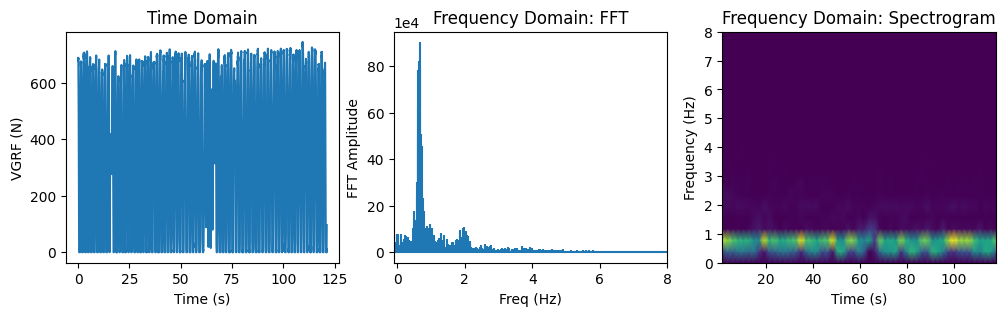

In [9]:
view_recording(patient_filename, column_names)

A few notes on this function:
* We removed the mean of the overall signal in the time domain before translating our data into the frequency domain in order to remove the FFT components at 0 Hz.
* Since our data was recorded at 100 Hz, Nyquist–Shannon Sampling Theorem states that we should be able to extract frequency information as high as 50 Hz. However, given that we are talking about gross motor coordination, we aren't going to worry too much about frequency information beyond 8 Hz.
* We could apply a digital filter to clean up our data a bit, but given that there does not seem to be a great deal of high-frequency information, we will forgo that step for now.

To generate our features, we are going to write five helper functions:
1. A function that will generate domain-inspired features related to the amplitude of a single foot
2. A function that will generate domain-inspired features related to the cadence of a single foot
3. A function that will generate arbitrary time-domain features
4. A function that will generate arbitrary frequency-domain features
5. A function that will compare corresponding features across both feet

In [10]:
def compute_amplitude_features(times, values, fs=100):
    """
    Calculate features related to the transient amplitude of the signal over time
    using a 5-second window with 0% overlap
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    # Set the sliding window parameters
    window_width = 5
    start_time = 0
    end_time = window_width
    sample_period = 1/fs
    middle_idx = int((window_width / sample_period) // 2)

    # Stop generating windows it would go past the end of the signal
    window_amplitudes = []
    while end_time < times.max():
        # Grab the current window by filtering indexes according to time
        window_idxs = (times >= start_time) & (times <= end_time)
        window_values = values[window_idxs]

        # Calculate the amplitude
        window_rms = np.sqrt(np.mean(window_values**2))
        window_amplitudes.append(window_rms)

        # Move the window over by a stride
        start_time += window_width
        end_time += window_width

    # Summarize the amplitude over time
    return {'average amplitude': np.mean(window_amplitudes),
            'stdev amplitude': np.std(window_amplitudes)}

In [11]:
def compute_cadence_features(times, values, fs=100):
    """
    Calculate features related to the transient peak frequency of the signal
    over time
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    # Calculate the spectrogram
    values_centered = values - values.mean()
    spec_freqs, spec_times, spectro = signal.spectrogram(values_centered, fs)

    # Find the largest bin along the frequency dimension
    dominant_bins = np.argmax(spectro, axis=0)

    # Map those bin indeces to frequencies
    peak_freqs = spec_freqs[dominant_bins]

    # Summarize the step rate over time
    return {'average cadence': np.mean(peak_freqs),
            'stdev cadence': np.std(peak_freqs)}

In [83]:
def compute_arbitrary_time_features(times, values, fs=100):
    """
    Calculates generic time-domain statistics on the signal
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    return {'average': np.mean(values),
            'stdev': np.std(values),
            '95th percentile': np.percentile(values, 95)}

In [71]:
def compute_arbitrary_freq_features(times, values, fs=100):
    """
    Calculates generic frequency-domain features on the signal
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    # Calculate the FFT
    values_centered = values - values.mean()
    fft_mag = np.abs(fft(values_centered))
    fft_freqs = fftfreq(len(values_centered), 1/fs)

    # Calculate the indices relevant to our frequency bands of interest
    low_indices = np.where((fft_freqs >= 0) & (fft_freqs <= 3))
    high_indices = np.where((fft_freqs >= 3) & (fft_freqs <= 8))

    # Calculate the power at the low and high frequencies
    low_power = np.sum(fft_mag[low_indices]**2)
    high_power = np.sum(fft_mag[high_indices]**2)

    # Calculate the power within the frequency range
    high_to_low_ratio = 10*np.log10(high_power / low_power)
    return {'power at low freqs': low_power,
            'power at high freqs': high_power,
            'high-to-low power ratio': high_to_low_ratio}

In [12]:
def compute_difference_features(left, right):
    """
    Compares corresponding features across two feet
    left: the dictionary of features from the left side
    right: the dictionary of features from the right side
    """
    diffs_dict = {}
    for key in left:
        diffs_dict[key] = np.abs(left[key] - right[key])
    return diffs_dict

## Extract the Features from All Recordings

Now that we have helper functions to calculate our features, let's put everything together into a single function. This function will take a single recording filename as input and return all of the features calculated for that recording as a `dict`.

In [84]:
def process_recording(filename):
    """
    Process a VGRF recording and produce all of the features according to
    the cardinal symptoms of Parkinson's disease as a dictionary (one value per key)
    filename: the name of the recording file
    """
    # Get the useful columns
    df = pd.read_csv(os.path.join(base_folder, filename),
                     sep="\t", header=None, names=column_names)
    time = df['Time'].values
    left_values = df['Left Foot'].values
    right_values = df['Right Foot'].values

    # Extract features from the left side
    left_amplitude = compute_amplitude_features(time, left_values)
    left_cadence = compute_cadence_features(time, left_values)
    left_time = compute_arbitrary_time_features(time, left_values)
    left_freq = compute_arbitrary_freq_features(time, left_values)

    # Extract features from the right side
    right_amplitude = compute_amplitude_features(time, right_values)
    right_cadence = compute_cadence_features(time, right_values)
    right_time = compute_arbitrary_time_features(time, right_values)
    right_freq = compute_arbitrary_freq_features(time, right_values)

    # Extract difference features
    diff_amplitude = compute_difference_features(left_amplitude, right_amplitude)
    diff_cadence = compute_difference_features(left_cadence, right_cadence)
    diff_time = compute_difference_features(left_time, right_time)
    diff_freq = compute_difference_features(left_freq, right_freq)

    # Combine everything into a feature vector
    feature_dict = {}
    for left_dict in [left_amplitude, left_cadence, left_time, left_freq]:
        for key in left_dict:
            feature_dict['Single foot ' + key] = left_dict[key]
    for diff_dict in [diff_amplitude, diff_cadence, diff_time, diff_freq]:
        for key in diff_dict:
            feature_dict['Difference ' + key] = diff_dict[key]
    return feature_dict

In [85]:
# Test our function
process_recording(control_filename)

{'Single foot average amplitude': 693.5650280862077,
 'Single foot stdev amplitude': 16.44048359744188,
 'Single foot average cadence': 0.78125,
 'Single foot stdev cadence': 0.0,
 'Single foot average': 520.6552240283852,
 'Single foot stdev': 458.4936828552102,
 'Single foot 95th percentile': 1081.74,
 'Single foot power at low freqs': 15068940744142.945,
 'Single foot power at high freqs': 353020083468.87054,
 'Single foot high-to-low power ratio': -16.302833118028076,
 'Difference average amplitude': 53.82010854365603,
 'Difference stdev amplitude': 6.527373128313728,
 'Difference average cadence': 0.0,
 'Difference stdev cadence': 0.0,
 'Difference average': 42.65903292350856,
 'Difference stdev': 32.85324752778189,
 'Difference 95th percentile': 38.5,
 'Difference power at low freqs': 2273223577071.283,
 'Difference power at high freqs': 8926702413.855286,
 'Difference high-to-low power ratio': 0.7214366649246351}

To get the features for all of the recordings in our dataset, we will iterate through all of the files and call our `process_recording()` function on each recording. Recall that we want to ignore any files that either (1) are not recording files, (2) come from control subjects, or (3) are numbered as trial 10. We will gather the results in a single `DataFrame` that will hold all of our features.

In [86]:
data_filenames = os.listdir(base_folder)

# Iterate through the filenames
features_df = pd.DataFrame()
for data_filename in data_filenames:
    # Skip the file if we want to ignore it
    patient_name = data_filename[0:6]
    patient_type = data_filename[2:4]
    trial_id = data_filename[7:9]
    if (patient_type == 'Co') or (trial_id == '10') or not ('_' in data_filename):
        continue

    # Generate the features
    feature_dict = process_recording(data_filename)

    # Add the patient's name as the identifier
    feature_dict['ID'] = patient_name
    feature_df = pd.DataFrame([feature_dict])
    features_df = pd.concat([features_df, feature_df], axis=0)

# Set the index to the image name
features_df.set_index(['ID'], inplace=True)
features_df

,Single foot average amplitude,Single foot stdev amplitude,Single foot average cadence,Single foot stdev cadence,Single foot average,Single foot stdev,Single foot 95th percentile,Single foot power at low freqs,Single foot power at high freqs,Single foot high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence,Difference average,Difference stdev,Difference 95th percentile,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio
ID,,,,,,,,,,,,,,,,,,,,
JuPt25,606.017956,18.236277,0.781250,0.000000,458.314713,397.043043,927.1900,7.337974e+12,1.755102e+11,-16.212738,4.898189,2.990532,0.000000,0.000000,2.835252,3.193896,4.0810,2.547593e+10,8.122058e+10,2.683280
JuPt21,605.198118,15.512378,0.775825,0.045715,467.480694,383.487465,942.5570,1.918975e+13,6.475310e+10,-24.718087,4.073191,0.003825,0.000000,0.000000,2.993825,0.119321,5.4670,1.909604e+10,9.541188e+09,0.696597
JuPt15,699.581072,13.499941,1.150760,0.088330,530.353904,458.088316,1121.1200,7.015536e+12,5.364167e+11,-11.165586,30.852073,2.334085,0.000000,0.000000,26.374884,18.153794,7.1500,5.244533e+11,7.617534e+10,0.327729
JuPt23,492.671693,9.752085,1.054688,0.179007,365.168741,331.447441,885.1810,4.198915e+12,3.960616e+11,-10.253744,10.305751,1.179075,0.009766,0.003952,20.757432,9.469676,61.7155,1.863048e+11,1.013179e+11,1.086081
JuPt15,699.089091,14.768402,1.116071,0.136690,529.936697,455.374611,1098.5975,8.762058e+12,6.226556e+11,-11.483582,28.524882,2.303695,0.000000,0.000000,18.468234,20.895932,31.4875,6.937085e+11,1.476701e+11,0.817461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SiPt28,560.804916,13.398958,0.773880,0.053148,433.456203,356.596243,899.7010,9.249971e+12,7.392505e+10,-20.973487,13.733481,0.400169,0.000000,0.000000,18.944752,0.734381,21.1200,3.219131e+09,4.121231e+10,1.925758
JuPt18,562.919691,22.619539,0.737847,0.122762,434.976560,359.441352,884.9500,4.470654e+13,1.845173e+11,-23.843338,52.161499,8.617599,0.003339,0.004250,48.286913,21.994030,57.7500,5.672494e+12,6.224065e+09,0.667810
SiPt18,647.951181,21.376649,0.781250,0.000000,485.128247,429.961130,1062.4900,1.341605e+13,1.415337e+11,-19.767647,21.645642,3.299875,0.000000,0.000000,1.764929,31.009436,109.1200,1.918808e+12,3.740005e+10,1.688634


Notice that because some subjects had multiple recordings, their ID appears multiple times in the index. That is usually not ideal for ensuring that that the each index uniquely points to a single row, but since we are only using the index for the sake of merging our data with the labels, this will be okay.

In [87]:
features_df.loc['JuPt15']

,Single foot average amplitude,Single foot stdev amplitude,Single foot average cadence,Single foot stdev cadence,Single foot average,Single foot stdev,Single foot 95th percentile,Single foot power at low freqs,Single foot power at high freqs,Single foot high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence,Difference average,Difference stdev,Difference 95th percentile,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio
ID,,,,,,,,,,,,,,,,,,,,
JuPt15,699.581072,13.499941,1.150760,0.088330,530.353904,458.088316,1121.1200,7.015536e+12,5.364167e+11,-11.165586,30.852073,2.334085,0.000000,0.000000,26.374884,18.153794,7.1500,5.244533e+11,7.617534e+10,0.327729
JuPt15,699.089091,14.768402,1.116071,0.136690,529.936697,455.374611,1098.5975,8.762058e+12,6.226556e+11,-11.483582,28.524882,2.303695,0.000000,0.000000,18.468234,20.895932,31.4875,6.937085e+11,1.476701e+11,0.817461
JuPt15,707.253349,23.939634,1.171875,0.000000,535.635508,462.200832,1119.5800,7.409230e+12,5.801044e+11,-11.062669,40.565273,4.185447,0.000000,0.000000,33.542411,22.704813,20.7570,6.523689e+11,1.203571e+11,0.609589
JuPt15,641.247171,25.874385,1.097470,0.153389,486.480835,416.726086,991.3200,7.619441e+12,4.471801e+11,-12.314407,16.007109,15.249667,0.009301,0.007812,10.019733,15.953624,50.3800,6.734300e+11,5.028021e+10,0.885833
JuPt15,696.633361,17.171798,1.161595,0.062528,527.461635,456.184112,1114.6520,7.313729e+12,5.583959e+11,-11.171966,27.010417,0.384322,0.000000,0.000000,20.686953,16.301422,8.0300,4.803778e+11,8.139450e+10,0.389174
JuPt15,698.168616,19.302214,1.151316,0.087225,527.554380,456.757376,1107.9750,7.227576e+12,5.462210e+11,-11.216243,28.399822,0.987686,0.000000,0.000000,20.896007,16.748839,6.4900,4.828804e+11,8.241761e+10,0.410042
JuPt15,696.165192,20.248906,1.141036,0.105335,524.493572,457.092764,1119.1400,7.361654e+12,5.507842e+11,-11.259939,25.131870,3.031991,0.000000,0.000000,14.659237,18.823945,12.6500,5.751886e+11,7.377749e+10,0.271252


## Grouping Features and Labels Together

 In our classifier example, we had a one-to-one mapping between rows in `labels_df` and rows in `features_df`. Here, however, each subject completed multiple trials. We will want to produce a prediction for each recording separately, so we will need to map one row in `labels_df` to many rows in `features_df`.

 We can still achieve this using the `merge()` method provided by `pandas` with one tweak. Instead of doing the default ***inner join***, which joins two `DataFrames` according to only the indices they have in common, we will do a ***right join***. A right join will result in a `DataFrame` with the same indices as the right `DataFrame` (i.e., inside the method), but it will add all of the information associated with those indices from the the left `DataFrame` (i.e. the one calling the method).

In [105]:
df = labels_df.merge(features_df, how='right', left_index=True, right_index=True)
df

,Sex,Age,Height,Weight,Label,Single foot average amplitude,Single foot stdev amplitude,Single foot average cadence,Single foot stdev cadence,Single foot average,...,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence,Difference average,Difference stdev,Difference 95th percentile,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio
ID,,,,,,,,,,,,,,,,,,,,,
GaPt03,1.0,82.0,1.45,50.0,10.0,444.421607,20.608348,0.722288,0.139841,343.433216,...,27.958919,0.175975,0.007370,0.007586,21.328273,19.256839,45.760,8.148191e+11,1.105764e+10,1.152139
GaPt04,NaN,NaN,NaN,NaN,NaN,606.495716,17.755803,0.766509,0.074436,465.003393,...,22.115557,2.678798,0.007370,0.021288,23.190122,5.202262,18.161,3.134335e+11,1.261027e+10,0.901248
GaPt05,1.0,82.0,1.53,51.0,5.0,547.556961,19.260221,0.803361,0.090267,411.277901,...,29.502260,1.132740,0.000000,0.000000,18.984544,22.689266,36.311,1.121864e+12,4.227267e+10,0.677072
GaPt06,0.0,72.0,1.70,82.0,13.0,721.965836,19.318869,0.781250,0.000000,557.588702,...,28.458919,4.186961,0.000000,0.000000,31.931614,5.647152,53.240,3.435866e+11,2.775412e+10,0.847240
GaPt07,1.0,53.0,1.67,54.0,22.0,401.990943,15.265978,0.781250,0.000000,307.865112,...,48.727985,3.704750,0.000000,0.000000,33.283818,35.847545,49.049,1.296596e+12,1.399435e+11,3.160799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SiPt36,1.0,53.0,1.58,62.0,32.0,479.608755,10.832136,0.788620,0.053148,358.826789,...,38.333603,4.064862,0.014741,0.037119,43.513700,7.901679,0.319,3.132062e+11,5.968487e+10,1.928532
SiPt37,1.0,66.0,1.70,62.0,21.0,446.941313,9.958952,0.781250,0.000000,345.079721,...,8.545315,7.355853,0.000000,0.000000,1.759691,11.187253,13.640,4.154555e+11,6.003682e+10,2.213339
SiPt38,1.0,65.0,1.59,60.0,14.0,425.577022,9.636840,0.788620,0.053148,326.260917,...,6.793150,0.431877,0.007370,0.053148,4.023083,5.800428,9.361,2.576747e+11,1.649682e+10,1.272530


We can confirm this worked by making sure that we have multiple entries for subjects who contributed multiple trials.

In [106]:
df.loc['JuPt15']

,Sex,Age,Height,Weight,Label,Single foot average amplitude,Single foot stdev amplitude,Single foot average cadence,Single foot stdev cadence,Single foot average,...,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence,Difference average,Difference stdev,Difference 95th percentile,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio
ID,,,,,,,,,,,,,,,,,,,,,
JuPt15,1.0,64.0,1.62,66.0,10.0,699.581072,13.499941,1.150760,0.088330,530.353904,...,30.852073,2.334085,0.000000,0.000000,26.374884,18.153794,7.1500,5.244533e+11,7.617534e+10,0.327729
JuPt15,1.0,64.0,1.62,66.0,10.0,699.089091,14.768402,1.116071,0.136690,529.936697,...,28.524882,2.303695,0.000000,0.000000,18.468234,20.895932,31.4875,6.937085e+11,1.476701e+11,0.817461
JuPt15,1.0,64.0,1.62,66.0,10.0,707.253349,23.939634,1.171875,0.000000,535.635508,...,40.565273,4.185447,0.000000,0.000000,33.542411,22.704813,20.7570,6.523689e+11,1.203571e+11,0.609589
JuPt15,1.0,64.0,1.62,66.0,10.0,641.247171,25.874385,1.097470,0.153389,486.480835,...,16.007109,15.249667,0.009301,0.007812,10.019733,15.953624,50.3800,6.734300e+11,5.028021e+10,0.885833
JuPt15,1.0,64.0,1.62,66.0,10.0,696.633361,17.171798,1.161595,0.062528,527.461635,...,27.010417,0.384322,0.000000,0.000000,20.686953,16.301422,8.0300,4.803778e+11,8.139450e+10,0.389174
JuPt15,1.0,64.0,1.62,66.0,10.0,698.168616,19.302214,1.151316,0.087225,527.554380,...,28.399822,0.987686,0.000000,0.000000,20.896007,16.748839,6.4900,4.828804e+11,8.241761e+10,0.410042
JuPt15,1.0,64.0,1.62,66.0,10.0,696.165192,20.248906,1.141036,0.105335,524.493572,...,25.131870,3.031991,0.000000,0.000000,14.659237,18.823945,12.6500,5.751886e+11,7.377749e+10,0.271252


Remember that we had to get rid of some subjects from `labels_df` since they were missing either their height, weight, or UPDRSM score. Because we did a right join rather than an inner join, subjects who were missing from the left `DataFrame` now have `NaN` for all of their demographic features and label. We will need to remove these rows yet again.

In [107]:
df = df[~pd.isna(df['Label'])]
df

,Sex,Age,Height,Weight,Label,Single foot average amplitude,Single foot stdev amplitude,Single foot average cadence,Single foot stdev cadence,Single foot average,...,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence,Difference average,Difference stdev,Difference 95th percentile,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio
ID,,,,,,,,,,,,,,,,,,,,,
GaPt03,1.0,82.0,1.45,50.0,10.0,444.421607,20.608348,0.722288,0.139841,343.433216,...,27.958919,0.175975,0.007370,0.007586,21.328273,19.256839,45.760,8.148191e+11,1.105764e+10,1.152139
GaPt05,1.0,82.0,1.53,51.0,5.0,547.556961,19.260221,0.803361,0.090267,411.277901,...,29.502260,1.132740,0.000000,0.000000,18.984544,22.689266,36.311,1.121864e+12,4.227267e+10,0.677072
GaPt06,0.0,72.0,1.70,82.0,13.0,721.965836,19.318869,0.781250,0.000000,557.588702,...,28.458919,4.186961,0.000000,0.000000,31.931614,5.647152,53.240,3.435866e+11,2.775412e+10,0.847240
GaPt07,1.0,53.0,1.67,54.0,22.0,401.990943,15.265978,0.781250,0.000000,307.865112,...,48.727985,3.704750,0.000000,0.000000,33.283818,35.847545,49.049,1.296596e+12,1.399435e+11,3.160799
GaPt07,1.0,53.0,1.67,54.0,22.0,407.763795,23.848561,0.751769,0.103184,319.467148,...,39.142952,3.350562,0.007370,0.012917,29.829560,27.310022,38.467,1.015065e+12,4.931373e+10,2.944462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SiPt36,1.0,53.0,1.58,62.0,32.0,479.608755,10.832136,0.788620,0.053148,358.826789,...,38.333603,4.064862,0.014741,0.037119,43.513700,7.901679,0.319,3.132062e+11,5.968487e+10,1.928532
SiPt37,1.0,66.0,1.70,62.0,21.0,446.941313,9.958952,0.781250,0.000000,345.079721,...,8.545315,7.355853,0.000000,0.000000,1.759691,11.187253,13.640,4.154555e+11,6.003682e+10,2.213339
SiPt38,1.0,65.0,1.59,60.0,14.0,425.577022,9.636840,0.788620,0.053148,326.260917,...,6.793150,0.431877,0.007370,0.053148,4.023083,5.800428,9.361,2.576747e+11,1.649682e+10,1.272530


# Step 3: Decide How the Data Should Be Split for Training and Testing

Because we have multiple trials from the same subjects, we cannot just use the `train_test_split()` function in order to split our dataset. Otherwise, we run the risk of having a subject's data across multiple splits. Unless we expect that subjects will provide labeled data as a sort of "personal calibration" for model training, this would constitute information leakage.

What we need to do is split the data while being cognizant that rows with the same `ID` should be grouped together. One convenient way we can do that is by using the `GroupKFold` class in `scikit-learn`. This object splits data according to k-fold cross-validation while keeping all of the samples associated with the same grouping variable in the same fold.

In the example below, we can see how `GroupKFold` splits our data into 5 folds while using the index of our `DataFrame` as the grouping variable:

In [108]:
from sklearn.model_selection import GroupKFold

# Set the random seed to an arbitrary number of your choosing
np.random.seed(42)

# Get the features, labels, and grouping variables
x = df.drop('Label', axis=1).values
y = df['Label'].values
groups = df.index.values

# Split the data into folds
group_kfold = GroupKFold(n_splits=5)
for train_idxs, test_idxs in group_kfold.split(x, y, groups):
    print(f'Train row idxs: {train_idxs}')
    print(f'Test row idxs: {test_idxs}')
    print('---------------')

Train row idxs: [  0   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  21  22
  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  69  70  71  72  73  74  75  76  77  78  79  80  81  90  91  92  93
  94  95  96  97  98  99 100 102 103 104 105 106 107 108 109 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 150 151 152 153 155 156 157
 158 160 161 162 163 165 166 167 168 170 171 172 173 175 176 177 178 180
 181]
Test row idxs: [  1   9  10  19  20  29  30  45  46  47  48  49  50  68  82  83  84  85
  86  87  88  89 101 110 111 112 113 114 115 116 149 154 159 164 169 174
 179]
---------------
Train row idxs: [  1   2   3   4   5   6   7   8   9  10  13  14  15  16  17  18  19  20
  23  24  25  26  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54 

There are more sophisiticated functions and classes we can use to automate the entire cross-validation procedure for us. However, we will use

# Step 4: (Optional) Add Feature Selection

We have explicitly included features that are inspired by domain expertise and our general knowledge about signal processing so that we can eventually try out feature selection. However, we are going to skip this step for now.

# Step 5: (Optional) Balance Your Dataset

Although there aren't distinct classes we can balance, we can still check that we have a reasonable distribution of UPDRSM scores. We will use this opportunity to show one of the ways that `pandas` interfaces with `matplotlib` to simplify how you can visualize data:

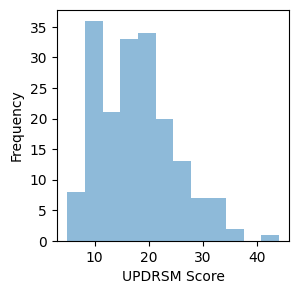

In [109]:
plt.figure(figsize=(3, 3))
df['Label'].plot.hist(bins=12, alpha=0.5)
plt.xlabel('UPDRSM Score')
plt.show()

Ideally, this would be a completely normal distribution with taller bars in the middle and shorter bars on either side. Although that isn't what we see here, most of the scores lie between 15–20 and we have scores that are above and below that range. Since there is no glaring imbalance in our dataset, it is probably not worth trying to balance our dataset and adding yet another step in our pipeline.

# Step 6: Select an Appropriate Model

`scikit-learn` provides numerous regression model architectures with their own advantages and disadvantages. For now, we are going to stick with a simple ***linear regressor***, which uses a weighted sum of features to make a prediction.

In [110]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

# Step 7: (Optional) Select Your Hyperparameters

For now, we are going to stick with the default hyperparameters for our model.

# Step 8: Train and Test Your Model

As with classification models, we can train a regression model by calling `.fit()` and generate predictions using `.predict()`. Since the predictions are going to be continuous values, there is no equivalent to the `.predict_proba()` method.

Sicne we are doing k-fold cross-validation, our train-and-test procedure is going to be more complicated. The pseudocode for the procedure is as follows:

```
initialize a data structure for saving our final results
for each fold:
    split data into train and test
    train a model on training data
    predict on the test data using that model
    append the predictions to our final results
ensure that the predictions in final results align with our original data
```

And here is that procedure in action:

In [113]:
# Initialize a data structure to save our final results,
# assuming all of the predictions are 0 to start
y_pred = np.zeros(y.shape)

# Split the data into folds
group_kfold = GroupKFold(n_splits=5)
for train_idxs, test_idxs in group_kfold.split(x, y, groups):
    # Split the data into train and test
    x_train = x[train_idxs]
    y_train = y[train_idxs]
    x_test = x[test_idxs]
    y_test = y[test_idxs]

    # Train a model on the training data
    reg = LinearRegression()
    reg.fit(x_train, y_train)

    # Predict on the test data
    y_test_pred = reg.predict(x_test)
    y_pred[test_idxs] = y_test_pred

`scikit-learn` provides a function called `cross_val_predict()` that will automate this procedure for us:

In [ ]:
from sklearn.model_selection import cross_val_predict

# Split the data into folds
group_kfold = GroupKFold(n_splits=5)

# Perform cross-validation and get the predictions
regressors = cross_val_predict(reg, x, y, cv=group_kfold,
                               return_estimator=True)

# Concatenate the predictions from each fold in the original order
y_pred = np.concatenate([est.predict(x) for est in regressors.estimators_])

However, we are going to stick with our manual implementation for two reasons: (1) it will reinforce what this procedure is doing, and (2) it will give us greater flexibility to change our pipeline in a later session.

As you get more familiar with `scikit-learn` and machine learning in general, you will discover for yourself which shortcuts you want to rely on.

# Step 9: Use an Appropriate Method for Interpreting Results

Now that we have predictions, we will examine a variety of metrics to see how well our model performed. Most of the functions we will discuss in this section require two inputs:
1. **y_true:** The known ground-truth labels from our dataset
2. **y_pred:** The labels predicted from the model

## Distance Metrics

The `metrics` module from `scikit-learn` provides multiple functions for evaluating the performance of a regression model. However, some of the most useful ones can be calculated using simply `numpy` operations:

In [119]:
print(f'Mean error: {np.mean(y_pred-y)}')
print(f'Mean absolute error: {np.mean(np.abs(y_pred-y))}')

Mean error: 0.06349616909671628
Mean absolute error: 5.040825329029288


## Correlation Metrics

`scipy` provides functions for calculating both Pearson's and Spearman's correlation. These functions return a special object that contains two values: the correlation coefficient and its p-value.

In [161]:
from scipy.stats import pearsonr, spearmanr

pcorr = pearsonr(y, y_pred)
scorr = spearmanr(y, y_pred)
print(f'Pearson correlation: r = {pcorr[0]:0.2f}, pval = {pcorr[1]:0.2f}')
print(f'Spearman correlation: r = {scorr[0]:0.2f}, pval = {scorr[1]:0.2f}')

Pearson correlation: r = 0.43, pval = 0.00
Spearman correlation: r = 0.46, pval = 0.00


We can also calculate the R2 score, also known as the coefficient of determination:

In [162]:
from sklearn.metrics import r2_score

print(f'R2 Score: {r2_score(y, y_pred)}')

R2 Score: 0.09541384849095591


To establish these correlation results further, we can plot them on a correlation plot:

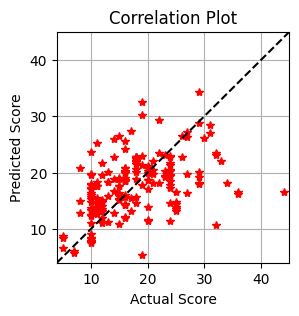

In [163]:
fig_bounds = [y.min()-1, y.max()+1]
plt.figure(figsize=(3, 3))
plt.plot(y, y_pred, 'r*')
plt.plot(fig_bounds, fig_bounds, 'k--')
plt.grid()
plt.xlim(fig_bounds), plt.ylim(fig_bounds)
plt.xlabel('Actual Score'), plt.ylabel('Predicted Score')
plt.title('Correlation Plot')
plt.show()

Another graph that can be useful for analyzing regression performance is a ***Bland-Altmann plot***. These graphs are designed to show how the agreement between two measurement methods varies according to their magnitude. Typically, the x-axis of these graphs is the average between the measurement methods (in this case, known labels and their corresponding predictions) and the y-axis is the difference between them.

However, this is the case when one measurement method does not take precedence over another. In our case, we know that one of the measurement methods is "correct". Therefore, we will create a modified Bland-Altmann plot where the x-axis is the known label and the y-axis is the difference between the prediction and the known label.

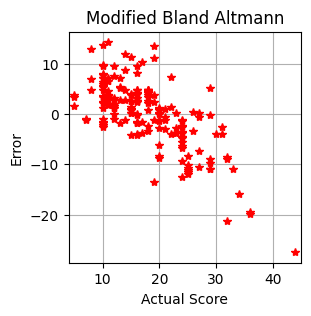

In [164]:
plt.figure(figsize=(3, 3))
plt.plot(y, y_pred-y, 'r*')
plt.grid()
plt.xlim(fig_bounds)
plt.xlabel('Actual Score'), plt.ylabel('Error')
plt.title('Modified Bland Altmann')
plt.show()

## Evaluating Performance

Let's create a function that will generate a detailed regression accuracy report combining the aforementioned metrics and visualizations:

In [157]:
def regression_evaluation(y_true, y_pred):
    """
    Generate a series of graphs that will help us determine the performance of
    a regression model
    y_true: the target labels
    y_pred: the predicted labels
    """
    # Calculate the distance metrics and Pearson's correlation
    mean_error = np.mean(y_pred-y)
    std_error = np.std(y_pred-y)
    mean_absolute_error = np.mean(np.abs(y_pred-y))
    corr, pval = pearsonr(y, y_pred)

    # Set up the graphs
    fig_bounds = [y.min()-1, y.max()+1]
    corr_title = f'Correlation = {corr:0.2f}'
    corr_title += ', p<.05' if pval <.05 else ', n.s.'
    ba_title = f'Mean Error = {mean_error:0.2f} ± {std_error:0.2f}'

    # Generate a correlation plot with the scores in the title
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    plt.plot(y, y_pred, 'r*')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.grid()
    plt.xlabel('Actual Score'), plt.ylabel('Predicted Score')
    plt.title(corr_title)

    plt.subplot(1, 2, 2)
    plt.plot(y, y_pred-y, 'r*')
    plt.axhline(y=mean_error, color='k', linestyle='--')
    plt.axhline(y=mean_error+std_error, color='b', linestyle='--')
    plt.axhline(y=mean_error-std_error, color='b', linestyle='--')
    plt.xlim(fig_bounds)
    plt.xlabel('Actual Score'), plt.ylabel('Error')
    plt.title(ba_title)
    plt.show()

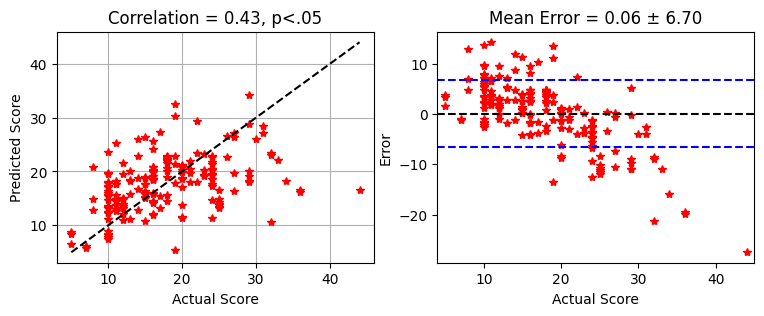

In [158]:
regression_evaluation(y, y_pred)

So what can we learn from these results:
* We achieved a non-trivial, positive correlation between our predictions and the known labels. Standard conventions suggest that a correlation between 0.3–0.5 can be considered *moderate*, while higher coefficients can be considered *strong*.
* Our model has a very slight tendency to overpredict scores. This is probably negligible though given the range and distribution of possible scores.
* Most of our score predictions are between 10 and 20, which one would expect given the range of labels in our dataset. However, this holds true even when the actual score is outside of those ranges. This bias for a regression model to produce predictions that gravitate towards the average in the dataset is sometimes called ***mean tracking***.
* The mean tracking is even more evident in the Bland-Altman. Notice how it has a diagonal shape that trends from the top-left to the bottom-right. This means that we tend to overestimate lower scores and underestimate higher scores, which is exactly what would happen if we were to predict the average.

We are going to revisit this machine learning pipeline in a later session to see how we can improve its performance.